In [19]:
# For Matrix Operations
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [20]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence
def Get_Vinyard(f, g, D, t = 101):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mx = 'hey'
    #mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l*dt
            L += l*dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1


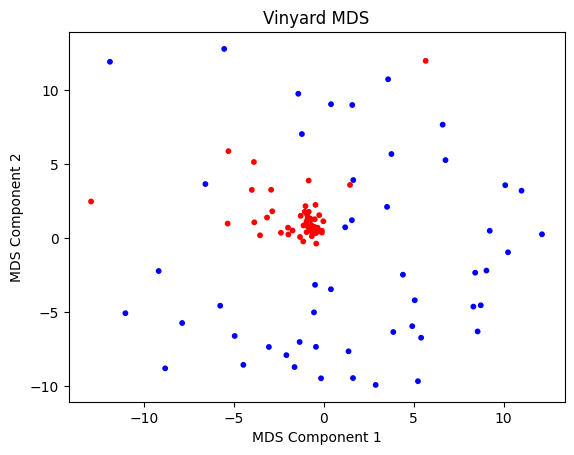

array([[ 0.        ,  1.03890542,  3.26740276, ..., 14.91512517,
        10.22630411,  7.01081234],
       [ 1.03890542,  0.        ,  1.02801066, ...,  9.92521556,
        15.37795451,  5.25285607],
       [ 3.26740276,  1.02801066,  0.        , ...,  9.49717814,
         9.4246916 ,  5.10840905],
       ...,
       [14.91512517,  9.92521556,  9.49717814, ...,  0.        ,
        13.36925318, 14.48066779],
       [10.22630411, 15.37795451,  9.4246916 , ..., 13.36925318,
         0.        , 11.62852765],
       [ 7.01081234,  5.25285607,  5.10840905, ..., 14.48066779,
        11.62852765,  0.        ]])

In [24]:
def Test_Mnist(N1, N2, dimension = 1, no_samples = 100):

    # fetching Mnist, finding a three and a eight. Creating an f and g for our test:

    X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
    # X is 70000 images, y is the classifications
    X.shape
    # taking each image and turning it into a 3d array. Each slide is a 28 by 28 grayscale grid

    X = X.reshape(X.shape[0],28,28)

    # finding all the 6's and 9's and filtering them out
    f = X[np.where(y == str(N1))]
    g = X[np.where(y == str(N2))]


    if no_samples > len(f) or no_samples >len(g):
        no_samples = max(len(f), len(g))
    f = f[:no_samples]
    g = g[:no_samples]

    Combined_Array = np.concatenate((f, g), axis = 0)

    # Distances Calculations
    Vinyard_Distances = np.zeros((Combined_Array.shape[0], Combined_Array.shape[0]))

    for i in range(Combined_Array.shape[0]):
        for j in range(i+1,Combined_Array.shape[0]):
            Vinyard_Distances[i,j] = vdist(Get_Vinyard(Combined_Array[i], Combined_Array[j],dimension, t = 25)[0],fD,fL)
    Vinyard_Distances += np.transpose(Vinyard_Distances)

    # MDS Embedding
    Vinyard_MDS_Embedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 32).fit_transform(Vinyard_Distances)


    # Plotting
    fig, ax = plt.subplots()

    # Red is N1 and Blue is N2
    scatter = ax.scatter(Vinyard_MDS_Embedding[:, 0], Vinyard_MDS_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


    plt.title('Vinyard MDS')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.show()
    return Vinyard_Distances
Test_Mnist(4,9, dimension = 1, no_samples = 50)